## RNN for Human Activity Recognition - 2D Pose Input

This experiment is the classification of human activities using a 2D pose time series dataset and an LSTM RNN.
The idea is to prove the concept that using a series of 2D poses, rather than 3D poses or a raw 2D images, can produce an accurate estimation of the behaviour of a person or animal.
This is a step towards creating a method of classifying an animal's current behaviour state and predicting it's likely next state, allowing for better interaction with an autonomous mobile robot.

## Objectives

The aims of this experiment are:

-  To determine if 2D pose has comparable accuracy to 3D pose for use in activity recognition. This would allow the use of RGB only cameras for human and animal pose estimation, as opposed to RGBD or a large motion capture dataset.


- To determine if  2D pose has comparable accuracy to using raw RGB images for use in activity recognition. This is based on the idea that limiting the input feature vector can help to deal with a limited dataset, as is likely to occur in animal activity recognition, by allowing for a smaller model to be used (citation required).


- To verify the concept for use in future works involving behaviour prediction from motion in 2D images.

The network used in this experiment is based on that of Guillaume Chevalier, 'LSTMs for Human Activity Recognition, 2016'  https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition, available under the MIT License.
Notable changes that have been made (other than accounting for dataset sizes) are:
 - Adapting for use with a large dataset ordered by class, using random sampling without replacement for mini-batch.  
 This allows for use of smaller batch sizes when using a dataset ordered by class. "It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize"  
      _N.S Keskar, D. Mudigere, et al, 'On Large-Batch Training for Deep Learning: Generalization Gap and Sharp 
      Minima', ICLR 2017_ https://arxiv.org/abs/1609.04836
      
 - Exponentially decaying learning rate implemented



## Dataset overview

The dataset consists of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset is comprised of 12 subjects doing the following 6 actions for 5 repetitions, filmed from 4 angles, repeated 5 times each.  

- JUMPING,
- JUMPING_JACKS,
- BOXING,
- WAVING_2HANDS,
- WAVING_1HAND,
- CLAPPING_HANDS.

In total, there are 1438 videos (2 were missing) made up of 211200 individual frames.

The below image is an example of the 4 camera views during the 'boxing' action for subject 1

![alt text](images/boxing_all_views.gif.png "Title")

The input for the LSTM is the 2D position of 18 joints across a timeseries of frames numbering n_steps (window-width), with an associated class label for the frame series.  
A single frame's input (where j refers to a joint) is stored as:

[  j0_x,  j0_y, j1_x, j1_y , j2_x, j2_y, j3_x, j3_y, j4_x, j4_y, j5_x, j5_y, j6_x, j6_y, j7_x, j7_y, j8_x, j8_y, j9_x, j9_y, j10_x, j10_y, j11_x, j11_y, j12_x, j12_y, j13_x, j13_y, j14_x, j14_y, j15_x, j15_y, j16_x, j16_y, j17_x, j17_y ]

For the following experiment, very little preprocessing has been done to the dataset.  
The following steps were taken:
1. openpose run on individual frames, for each subject, action and view, outputting JSON of 18 joint x and y position keypoints and accuracies per frame
2. JSONs converted into txt format, keeping only x and y positions of each frame, action being performed during frame, and order of frames. This is used to create a database of associated activity class number and corresponding series of joint 2D positions
3. No further prepossessing was performed.  

In some cases, multiple people were detected in each frame, in which only the first detection was used.

The data has not been normalised with regards to subject position in the frame, motion across frame (if any), size of the subject, speed of action etc. It is essentially the raw 2D position of each joint viewed from a stationary camera.  
In many cases, individual joints were not located and a position of [0.0,0.0] was given for that joint

A summary of the dataset used for input is:

 - 211200 individual images 
 - n_steps = 32 frames (~=1.5s at 22Hz)
 - Images with noisy pose detection (detection of >=2 people) = 5132  
 - Training_split = 0.8
 - Overlap = 0.8125 (26 / 32) ie 26 frame overlap
   - Length X_train = 22625 * 32 frames
   - Length X_test = 5751 * 32 frames
   
Note that their is no overlap between test and train sets, which were seperated by activity repetition entirely, before creating the 26 of 32 frame overlap.




## Training and Results below: 
Training took approximately 4 mins running on a single GTX1080Ti, and was run for 22,000,000ish iterations with a batch size of 5000  (600 epochs)


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os

D:\PF~4\Python\AN~3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Preparing dataset:

In [2]:
# Useful Constants

# Output classes to learn how to classify
# LABELS = [    
#     "JUMPING",
#     "JUMPING_JACKS",
# #     "BOXING",
#     "WAVING_2HANDS",
#     "WAVING_1HAND",
#     "CLAPPING_HANDS"
# ] 

LABELS = [    
    "GO_IN",
    "GO_OUT",
    "WALK_LEFT",
    "WALK_RIGHT"
] 

# DATASET_PATH = "data/HAR_pose_activities/database/"
DATASET_PATH = "data/Overlap_fixed4_separated/"
# DATASET_PATH = "data/HAR_pose_activities/database/Training Default/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"
# X_test_path = "utilities/something/something.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

# n_steps = 32 # 32 timesteps per series
n_steps = 5 # 32 timesteps per series
# n_steps = 1 # 32 timesteps per series

In [3]:

# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


## Set Parameters:


In [4]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

n_hidden = 34 # Hidden layer num of features
# n_classes = 6 
n_classes = len(LABELS)

#updated for learning-rate decay
# calculated as: decayed_learning_rate = init_learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 #used if decaying_learning_rate set to False
init_learning_rate = 0.005
decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

# training_iters = training_data_count *300  # Loop 300 times on the dataset, ie 300 epochs
# training_iters = training_data_count *60
# training_iters = training_data_count *120
# training_iters = training_data_count *1
# batch_size = 5
batch_size = 60
# batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




(X shape, y shape, every X's mean, every X's standard deviation)
(1005, 5, 36) (1010, 1) 226.44403 140.37772

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [5]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        
        _unsampled = list(_unsampled)
        
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [6]:
# for _ in range(3):
#     tf.reset_default_graph()
#     var = tf.Variable(0)
#     with tf.Session() as session:
#         session.run(tf.global_variables_initializer())
#         print(len(session.graph._nodes_by_name.keys()))

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

# correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
print(biases)
print(weights['hidden'])

{'out': <tf.Variable 'Variable_4:0' shape=(4,) dtype=float32_ref>, 'hidden': <tf.Variable 'Variable_3:0' shape=(34,) dtype=float32_ref>}
<tf.Variable 'Variable_1:0' shape=(36, 34) dtype=float32_ref>


In [9]:
# if decaying_learning_rate:
#     learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)

## Train the network:

In [10]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()

sess.run(init)

In [11]:
# training_iters = training_data_count *120
# training_iters = training_data_count *5120
# training_iters = training_data_count *2560
training_iters = training_data_count *1024

#create saver before training
# saver = tf.train.Saver()
saver = tf.train.Saver(var_list={'wh':weights['hidden'], 'wo':weights['out'], 'bh':biases['hidden'], 'bo':biases['out']})
load = False
train = True
update = True

#check if you want to retrain or import a saved model
if load:
    saver.restore(sess, DATASET_PATH + "model.ckpt")
    print("Model restored.")

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [12]:
# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = range(0,len(X_train))

if not train:
    
    # only perform testing
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )
    
    print("PERFORMANCE ON TEST SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))

while train and (step * batch_size <= training_iters):
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = range(0,len(X_train)) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy_fin, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy_fin)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy_fin))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #60:  Learning rate = 0.005000:   Batch Loss = 3.000730, Accuracy = 0.3333333432674408
PERFORMANCE ON TEST SET:             Batch Loss = 2.6848299503326416, Accuracy = 0.3495049476623535
Iter #480:  Learning rate = 0.005000:   Batch Loss = 2.532169, Accuracy = 0.3499999940395355
PERFORMANCE ON TEST SET:             Batch Loss = 2.5582127571105957, Accuracy = 0.3386138677597046
Iter #960:  Learning rate = 0.005000:   Batch Loss = 2.488724, Accuracy = 0.44999998807907104
PERFORMANCE ON TEST SET:             Batch Loss = 2.4342355728149414, Accuracy = 0.4801980257034302
Iter #1440:  Learning rate = 0.005000:   Batch Loss = 2.330377, Accuracy = 0.4833333194255829
PERFORMANCE ON TEST SET:             Batch Loss = 2.3621773719787598, Accuracy = 0.4356435537338257
Iter #1920:  Learning rate = 0.005000:   Batch Loss = 2.323692, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.3205325603485107, Accuracy = 0.49405941367149353
Iter #2400:  Learning rate = 0.005000:   Batch 

Iter #21120:  Learning rate = 0.005000:   Batch Loss = 1.685537, Accuracy = 0.5833333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 1.8479132652282715, Accuracy = 0.5534653663635254
Iter #21600:  Learning rate = 0.005000:   Batch Loss = 1.811218, Accuracy = 0.6499999761581421
PERFORMANCE ON TEST SET:             Batch Loss = 1.845954418182373, Accuracy = 0.5594059228897095
Iter #22080:  Learning rate = 0.005000:   Batch Loss = 1.952353, Accuracy = 0.4166666567325592
PERFORMANCE ON TEST SET:             Batch Loss = 1.9013092517852783, Accuracy = 0.48613861203193665
Iter #22560:  Learning rate = 0.005000:   Batch Loss = 1.816046, Accuracy = 0.5166666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 1.8780593872070312, Accuracy = 0.5198019742965698
Iter #23040:  Learning rate = 0.005000:   Batch Loss = 1.729033, Accuracy = 0.6166666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 1.850522756576538, Accuracy = 0.5633663535118103
Iter #23520:  Learning rat

Iter #41760:  Learning rate = 0.005000:   Batch Loss = 1.687213, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.722165584564209, Accuracy = 0.5188118815422058
Iter #42240:  Learning rate = 0.005000:   Batch Loss = 1.657632, Accuracy = 0.6333333253860474
PERFORMANCE ON TEST SET:             Batch Loss = 1.737539529800415, Accuracy = 0.5435643792152405
Iter #42720:  Learning rate = 0.005000:   Batch Loss = 1.731739, Accuracy = 0.4833333194255829
PERFORMANCE ON TEST SET:             Batch Loss = 1.7639024257659912, Accuracy = 0.502970278263092
Iter #43200:  Learning rate = 0.005000:   Batch Loss = 1.773436, Accuracy = 0.46666666865348816
PERFORMANCE ON TEST SET:             Batch Loss = 1.7606180906295776, Accuracy = 0.4920791983604431
Iter #43680:  Learning rate = 0.005000:   Batch Loss = 1.733030, Accuracy = 0.5833333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 1.6946486234664917, Accuracy = 0.5554455518722534
Iter #44160:  Learning rate = 0.005000:   

Iter #62400:  Learning rate = 0.005000:   Batch Loss = 1.543455, Accuracy = 0.6000000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 1.511366605758667, Accuracy = 0.5811881422996521
Iter #62880:  Learning rate = 0.005000:   Batch Loss = 1.378011, Accuracy = 0.6166666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 1.5035066604614258, Accuracy = 0.5722772479057312
Iter #63360:  Learning rate = 0.005000:   Batch Loss = 1.535634, Accuracy = 0.5666666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 1.5338695049285889, Accuracy = 0.5732673406600952
Iter #63840:  Learning rate = 0.005000:   Batch Loss = 1.371154, Accuracy = 0.5333333611488342
PERFORMANCE ON TEST SET:             Batch Loss = 1.5081298351287842, Accuracy = 0.5831683278083801
Iter #64320:  Learning rate = 0.005000:   Batch Loss = 1.508483, Accuracy = 0.5666666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 1.5412629842758179, Accuracy = 0.5326732397079468
Iter #64800:  Learning rat

Iter #83520:  Learning rate = 0.005000:   Batch Loss = 1.452160, Accuracy = 0.5666666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 1.4731948375701904, Accuracy = 0.5356435775756836
Iter #84000:  Learning rate = 0.005000:   Batch Loss = 1.292314, Accuracy = 0.6833333373069763
PERFORMANCE ON TEST SET:             Batch Loss = 1.4577064514160156, Accuracy = 0.5613861680030823
Iter #84480:  Learning rate = 0.005000:   Batch Loss = 1.473793, Accuracy = 0.5333333611488342
PERFORMANCE ON TEST SET:             Batch Loss = 1.4465138912200928, Accuracy = 0.5643564462661743
Iter #84960:  Learning rate = 0.005000:   Batch Loss = 1.259652, Accuracy = 0.6833333373069763
PERFORMANCE ON TEST SET:             Batch Loss = 1.4454946517944336, Accuracy = 0.5495049357414246
Iter #85440:  Learning rate = 0.005000:   Batch Loss = 1.333691, Accuracy = 0.6333333253860474
PERFORMANCE ON TEST SET:             Batch Loss = 1.487476110458374, Accuracy = 0.5118811726570129
Iter #85920:  Learning rat

Iter #105120:  Learning rate = 0.004800:   Batch Loss = 1.179159, Accuracy = 0.6000000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 1.340811014175415, Accuracy = 0.5752475261688232
Iter #105600:  Learning rate = 0.004800:   Batch Loss = 1.211304, Accuracy = 0.6166666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 1.351800799369812, Accuracy = 0.5514851212501526
Iter #106080:  Learning rate = 0.004800:   Batch Loss = 1.260238, Accuracy = 0.5666666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 1.3664933443069458, Accuracy = 0.5554455518722534
Iter #106560:  Learning rate = 0.004800:   Batch Loss = 1.513700, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.445439338684082, Accuracy = 0.5207920670509338
Iter #107040:  Learning rate = 0.004800:   Batch Loss = 1.386242, Accuracy = 0.5166666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 1.3978052139282227, Accuracy = 0.5306930541992188
Iter #107520:  Learning rate = 0.00480

Iter #126720:  Learning rate = 0.004800:   Batch Loss = 1.345726, Accuracy = 0.550000011920929
PERFORMANCE ON TEST SET:             Batch Loss = 1.302715539932251, Accuracy = 0.5742574334144592
Iter #127200:  Learning rate = 0.004800:   Batch Loss = 1.192301, Accuracy = 0.6666666865348816
PERFORMANCE ON TEST SET:             Batch Loss = 1.2984191179275513, Accuracy = 0.5643564462661743
Iter #127680:  Learning rate = 0.004800:   Batch Loss = 1.349805, Accuracy = 0.5666666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 1.3080300092697144, Accuracy = 0.5613861680030823
Iter #128160:  Learning rate = 0.004800:   Batch Loss = 1.334885, Accuracy = 0.550000011920929
PERFORMANCE ON TEST SET:             Batch Loss = 1.3021177053451538, Accuracy = 0.5207920670509338
Iter #128640:  Learning rate = 0.004800:   Batch Loss = 1.236112, Accuracy = 0.6666666865348816
PERFORMANCE ON TEST SET:             Batch Loss = 1.2901535034179688, Accuracy = 0.5801980495452881
Iter #129120:  Learning

Iter #148320:  Learning rate = 0.004800:   Batch Loss = 1.617247, Accuracy = 0.4000000059604645
PERFORMANCE ON TEST SET:             Batch Loss = 1.429112434387207, Accuracy = 0.5287128686904907
Iter #148800:  Learning rate = 0.004800:   Batch Loss = 1.404204, Accuracy = 0.46666666865348816
PERFORMANCE ON TEST SET:             Batch Loss = 1.436368703842163, Accuracy = 0.49405941367149353
Iter #149280:  Learning rate = 0.004800:   Batch Loss = 1.469689, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.3998271226882935, Accuracy = 0.5168316960334778
Iter #149760:  Learning rate = 0.004800:   Batch Loss = 1.393310, Accuracy = 0.4833333194255829
PERFORMANCE ON TEST SET:             Batch Loss = 1.4383212327957153, Accuracy = 0.5326732397079468
Iter #150240:  Learning rate = 0.004800:   Batch Loss = 1.378003, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.4048364162445068, Accuracy = 0.5168316960334778
Iter #150720:  Learning rate = 0.004800:   Batch L

Iter #169920:  Learning rate = 0.004800:   Batch Loss = 1.285803, Accuracy = 0.5833333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 1.360680341720581, Accuracy = 0.5267326831817627
Iter #170400:  Learning rate = 0.004800:   Batch Loss = 1.453229, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 1.3508611917495728, Accuracy = 0.5188118815422058
Iter #170880:  Learning rate = 0.004800:   Batch Loss = 1.150477, Accuracy = 0.6166666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 1.304823637008667, Accuracy = 0.5673267245292664
Iter #171360:  Learning rate = 0.004800:   Batch Loss = 1.302368, Accuracy = 0.5166666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 1.3491307497024536, Accuracy = 0.5594059228897095
Iter #171840:  Learning rate = 0.004800:   Batch Loss = 1.236526, Accuracy = 0.6333333253860474
PERFORMANCE ON TEST SET:             Batch Loss = 1.3690361976623535, Accuracy = 0.5277227759361267
Iter #172320:  Learning rate = 0.0048

Iter #191520:  Learning rate = 0.004800:   Batch Loss = 1.243405, Accuracy = 0.6166666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 1.2903531789779663, Accuracy = 0.5504950284957886
Iter #192000:  Learning rate = 0.004800:   Batch Loss = 1.275673, Accuracy = 0.4833333194255829
PERFORMANCE ON TEST SET:             Batch Loss = 1.3624563217163086, Accuracy = 0.5178217887878418
Iter #192480:  Learning rate = 0.004800:   Batch Loss = 1.287436, Accuracy = 0.5166666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 1.3330830335617065, Accuracy = 0.4811881184577942
Iter #192960:  Learning rate = 0.004800:   Batch Loss = 1.334873, Accuracy = 0.550000011920929
PERFORMANCE ON TEST SET:             Batch Loss = 1.3425557613372803, Accuracy = 0.513861358165741
Iter #193440:  Learning rate = 0.004800:   Batch Loss = 1.334716, Accuracy = 0.5166666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 1.3249528408050537, Accuracy = 0.512871265411377
Iter #193920:  Learning

Iter #213120:  Learning rate = 0.004608:   Batch Loss = 1.145737, Accuracy = 0.5833333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 1.221211552619934, Accuracy = 0.6118811964988708
Iter #213600:  Learning rate = 0.004608:   Batch Loss = 1.272362, Accuracy = 0.6000000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 1.2099348306655884, Accuracy = 0.6178217530250549
Iter #214080:  Learning rate = 0.004608:   Batch Loss = 1.263008, Accuracy = 0.5666666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 1.218787670135498, Accuracy = 0.5871286988258362
Iter #214560:  Learning rate = 0.004608:   Batch Loss = 1.031549, Accuracy = 0.6666666865348816
PERFORMANCE ON TEST SET:             Batch Loss = 1.2182748317718506, Accuracy = 0.5782178044319153
Iter #215040:  Learning rate = 0.004608:   Batch Loss = 1.144793, Accuracy = 0.6833333373069763
PERFORMANCE ON TEST SET:             Batch Loss = 1.2141058444976807, Accuracy = 0.5960395932197571
Iter #215520:  Learnin

Iter #234720:  Learning rate = 0.004608:   Batch Loss = 1.268908, Accuracy = 0.5666666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 1.1960301399230957, Accuracy = 0.5742574334144592
Iter #235200:  Learning rate = 0.004608:   Batch Loss = 1.134902, Accuracy = 0.5833333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 1.1952693462371826, Accuracy = 0.6000000238418579
Iter #235680:  Learning rate = 0.004608:   Batch Loss = 0.984539, Accuracy = 0.699999988079071
PERFORMANCE ON TEST SET:             Batch Loss = 1.2028141021728516, Accuracy = 0.594059407711029
Iter #236160:  Learning rate = 0.004608:   Batch Loss = 1.163305, Accuracy = 0.5833333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 1.1805176734924316, Accuracy = 0.593069314956665
Iter #236640:  Learning rate = 0.004608:   Batch Loss = 1.088651, Accuracy = 0.6000000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 1.2266331911087036, Accuracy = 0.5851485133171082
Iter #237120:  Learning

Iter #255840:  Learning rate = 0.004608:   Batch Loss = 1.121993, Accuracy = 0.6666666865348816
PERFORMANCE ON TEST SET:             Batch Loss = 1.1572147607803345, Accuracy = 0.6346534490585327
Iter #256320:  Learning rate = 0.004608:   Batch Loss = 1.074739, Accuracy = 0.6499999761581421
PERFORMANCE ON TEST SET:             Batch Loss = 1.1453291177749634, Accuracy = 0.6207920908927917
Iter #256800:  Learning rate = 0.004608:   Batch Loss = 0.985891, Accuracy = 0.699999988079071
PERFORMANCE ON TEST SET:             Batch Loss = 1.1508156061172485, Accuracy = 0.6415841579437256
Iter #257280:  Learning rate = 0.004608:   Batch Loss = 0.877366, Accuracy = 0.7666666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 1.1417940855026245, Accuracy = 0.6346534490585327
Iter #257760:  Learning rate = 0.004608:   Batch Loss = 1.032047, Accuracy = 0.699999988079071
PERFORMANCE ON TEST SET:             Batch Loss = 1.1298766136169434, Accuracy = 0.6495049595832825
Iter #258240:  Learnin

Iter #276000:  Learning rate = 0.004608:   Batch Loss = 1.365615, Accuracy = 0.44999998807907104
PERFORMANCE ON TEST SET:             Batch Loss = 1.127719759941101, Accuracy = 0.6702970266342163
Iter #276480:  Learning rate = 0.004608:   Batch Loss = 1.011684, Accuracy = 0.6499999761581421
PERFORMANCE ON TEST SET:             Batch Loss = 1.14219069480896, Accuracy = 0.6366336345672607
Iter #276960:  Learning rate = 0.004608:   Batch Loss = 1.277903, Accuracy = 0.5166666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 1.1220457553863525, Accuracy = 0.6603960394859314
Iter #277440:  Learning rate = 0.004608:   Batch Loss = 1.138156, Accuracy = 0.5833333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 1.1100348234176636, Accuracy = 0.6702970266342163
Iter #277920:  Learning rate = 0.004608:   Batch Loss = 0.869372, Accuracy = 0.7833333611488342
PERFORMANCE ON TEST SET:             Batch Loss = 1.1330403089523315, Accuracy = 0.6475247740745544
Iter #278400:  Learnin

Iter #296160:  Learning rate = 0.004608:   Batch Loss = 0.925206, Accuracy = 0.7166666388511658
PERFORMANCE ON TEST SET:             Batch Loss = 1.1188085079193115, Accuracy = 0.6544554233551025
Iter #296640:  Learning rate = 0.004608:   Batch Loss = 0.902224, Accuracy = 0.7333333492279053
PERFORMANCE ON TEST SET:             Batch Loss = 1.1065207719802856, Accuracy = 0.6574257612228394
Iter #297120:  Learning rate = 0.004608:   Batch Loss = 1.224872, Accuracy = 0.6166666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 1.1356061697006226, Accuracy = 0.6435643434524536
Iter #297600:  Learning rate = 0.004608:   Batch Loss = 0.986928, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.1350804567337036, Accuracy = 0.6366336345672607
Iter #298080:  Learning rate = 0.004608:   Batch Loss = 1.010711, Accuracy = 0.6499999761581421
PERFORMANCE ON TEST SET:             Batch Loss = 1.1630339622497559, Accuracy = 0.592079222202301
Iter #298560:  Learning rate = 0.00

Iter #316800:  Learning rate = 0.004424:   Batch Loss = 1.045403, Accuracy = 0.6499999761581421
PERFORMANCE ON TEST SET:             Batch Loss = 1.1574327945709229, Accuracy = 0.6118811964988708
Iter #317280:  Learning rate = 0.004424:   Batch Loss = 1.000540, Accuracy = 0.7166666388511658
PERFORMANCE ON TEST SET:             Batch Loss = 1.1211920976638794, Accuracy = 0.6495049595832825
Iter #317760:  Learning rate = 0.004424:   Batch Loss = 1.028127, Accuracy = 0.6666666865348816
PERFORMANCE ON TEST SET:             Batch Loss = 1.0878026485443115, Accuracy = 0.6821781992912292
Iter #318240:  Learning rate = 0.004424:   Batch Loss = 1.117192, Accuracy = 0.6833333373069763
PERFORMANCE ON TEST SET:             Batch Loss = 1.126128911972046, Accuracy = 0.6277227997779846
Iter #318720:  Learning rate = 0.004424:   Batch Loss = 1.082660, Accuracy = 0.6666666865348816
PERFORMANCE ON TEST SET:             Batch Loss = 1.1031337976455688, Accuracy = 0.6643564105033875
Iter #319200:  Learni

PERFORMANCE ON TEST SET:             Batch Loss = 1.1008362770080566, Accuracy = 0.6504950523376465
Iter #338400:  Learning rate = 0.004424:   Batch Loss = 1.070603, Accuracy = 0.699999988079071
PERFORMANCE ON TEST SET:             Batch Loss = 1.0869839191436768, Accuracy = 0.6693069338798523
Iter #338880:  Learning rate = 0.004424:   Batch Loss = 1.006989, Accuracy = 0.6833333373069763
PERFORMANCE ON TEST SET:             Batch Loss = 1.0689141750335693, Accuracy = 0.6732673048973083
Iter #339360:  Learning rate = 0.004424:   Batch Loss = 1.011873, Accuracy = 0.7333333492279053
PERFORMANCE ON TEST SET:             Batch Loss = 1.0667939186096191, Accuracy = 0.6920791864395142
Iter #339840:  Learning rate = 0.004424:   Batch Loss = 1.086972, Accuracy = 0.7333333492279053
PERFORMANCE ON TEST SET:             Batch Loss = 1.0794503688812256, Accuracy = 0.6722772121429443
Iter #340320:  Learning rate = 0.004424:   Batch Loss = 1.064609, Accuracy = 0.6166666746139526
PERFORMANCE ON TEST S

Iter #359520:  Learning rate = 0.004424:   Batch Loss = 0.989342, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0644639730453491, Accuracy = 0.711881160736084
Iter #360000:  Learning rate = 0.004424:   Batch Loss = 0.896317, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0271046161651611, Accuracy = 0.7277227640151978
Iter #360480:  Learning rate = 0.004424:   Batch Loss = 0.892330, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0450263023376465, Accuracy = 0.7039604187011719
Iter #360960:  Learning rate = 0.004424:   Batch Loss = 0.908017, Accuracy = 0.800000011920929
PERFORMANCE ON TEST SET:             Batch Loss = 1.0496320724487305, Accuracy = 0.696039617061615
Iter #361440:  Learning rate = 0.004424:   Batch Loss = 1.152527, Accuracy = 0.6333333253860474
PERFORMANCE ON TEST SET:             Batch Loss = 1.0529930591583252, Accuracy = 0.709900975227356
Iter #361920:  Learning rate = 0.004424:   Batch Loss = 0.846679, 

Iter #380160:  Learning rate = 0.004424:   Batch Loss = 1.142757, Accuracy = 0.6666666865348816
PERFORMANCE ON TEST SET:             Batch Loss = 1.079988718032837, Accuracy = 0.6762376427650452
Iter #380640:  Learning rate = 0.004424:   Batch Loss = 0.972092, Accuracy = 0.6833333373069763
PERFORMANCE ON TEST SET:             Batch Loss = 1.0746922492980957, Accuracy = 0.6881188154220581
Iter #381120:  Learning rate = 0.004424:   Batch Loss = 1.097369, Accuracy = 0.6666666865348816
PERFORMANCE ON TEST SET:             Batch Loss = 1.0815436840057373, Accuracy = 0.684158444404602
Iter #381600:  Learning rate = 0.004424:   Batch Loss = 0.864658, Accuracy = 0.7833333611488342
PERFORMANCE ON TEST SET:             Batch Loss = 1.144758939743042, Accuracy = 0.6465346813201904
Iter #382080:  Learning rate = 0.004424:   Batch Loss = 1.065160, Accuracy = 0.6833333373069763
PERFORMANCE ON TEST SET:             Batch Loss = 1.135664701461792, Accuracy = 0.6722772121429443
Iter #382560:  Learning 

Iter #400800:  Learning rate = 0.004247:   Batch Loss = 0.976573, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.0234227180480957, Accuracy = 0.6792079210281372
Iter #401280:  Learning rate = 0.004247:   Batch Loss = 1.043443, Accuracy = 0.699999988079071
PERFORMANCE ON TEST SET:             Batch Loss = 1.0208635330200195, Accuracy = 0.7247524857521057
Iter #401760:  Learning rate = 0.004247:   Batch Loss = 0.984056, Accuracy = 0.699999988079071
PERFORMANCE ON TEST SET:             Batch Loss = 1.0338919162750244, Accuracy = 0.7138614058494568
Iter #402240:  Learning rate = 0.004247:   Batch Loss = 0.859534, Accuracy = 0.8333333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 1.031101942062378, Accuracy = 0.7168316841125488
Iter #402720:  Learning rate = 0.004247:   Batch Loss = 0.936788, Accuracy = 0.699999988079071
PERFORMANCE ON TEST SET:             Batch Loss = 1.035939335823059, Accuracy = 0.709900975227356
Iter #403200:  Learning rate = 0.004247:

PERFORMANCE ON TEST SET:             Batch Loss = 1.0055245161056519, Accuracy = 0.7217822074890137
Iter #422880:  Learning rate = 0.004247:   Batch Loss = 0.934859, Accuracy = 0.800000011920929
PERFORMANCE ON TEST SET:             Batch Loss = 1.00429105758667, Accuracy = 0.7178217768669128
Iter #423360:  Learning rate = 0.004247:   Batch Loss = 0.960238, Accuracy = 0.699999988079071
PERFORMANCE ON TEST SET:             Batch Loss = 1.0207622051239014, Accuracy = 0.7029703259468079
Iter #423840:  Learning rate = 0.004247:   Batch Loss = 0.888412, Accuracy = 0.7333333492279053
PERFORMANCE ON TEST SET:             Batch Loss = 0.9954763650894165, Accuracy = 0.7287128567695618
Iter #424320:  Learning rate = 0.004247:   Batch Loss = 0.894214, Accuracy = 0.7666666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 1.0207853317260742, Accuracy = 0.7059406042098999
Iter #424800:  Learning rate = 0.004247:   Batch Loss = 1.012631, Accuracy = 0.699999988079071
PERFORMANCE ON TEST SET: 

Iter #443040:  Learning rate = 0.004247:   Batch Loss = 1.176079, Accuracy = 0.6833333373069763
PERFORMANCE ON TEST SET:             Batch Loss = 1.0099735260009766, Accuracy = 0.7336633801460266
Iter #443520:  Learning rate = 0.004247:   Batch Loss = 0.863826, Accuracy = 0.7166666388511658
PERFORMANCE ON TEST SET:             Batch Loss = 0.9616316556930542, Accuracy = 0.7554455399513245
Iter #444000:  Learning rate = 0.004247:   Batch Loss = 0.830376, Accuracy = 0.7666666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 1.0062222480773926, Accuracy = 0.7326732873916626
Iter #444480:  Learning rate = 0.004247:   Batch Loss = 1.161054, Accuracy = 0.6666666865348816
PERFORMANCE ON TEST SET:             Batch Loss = 1.0588083267211914, Accuracy = 0.6891089081764221
Iter #444960:  Learning rate = 0.004247:   Batch Loss = 0.805910, Accuracy = 0.7666666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 1.078274130821228, Accuracy = 0.6801980137825012
Iter #445440:  Learni

Iter #463680:  Learning rate = 0.004247:   Batch Loss = 1.079061, Accuracy = 0.6666666865348816
PERFORMANCE ON TEST SET:             Batch Loss = 0.9908202290534973, Accuracy = 0.7336633801460266
Iter #464160:  Learning rate = 0.004247:   Batch Loss = 0.845516, Accuracy = 0.7166666388511658
PERFORMANCE ON TEST SET:             Batch Loss = 0.9801931381225586, Accuracy = 0.7366336584091187
Iter #464640:  Learning rate = 0.004247:   Batch Loss = 0.843353, Accuracy = 0.7833333611488342
PERFORMANCE ON TEST SET:             Batch Loss = 1.0122642517089844, Accuracy = 0.7267326712608337
Iter #465120:  Learning rate = 0.004247:   Batch Loss = 0.927554, Accuracy = 0.7333333492279053
PERFORMANCE ON TEST SET:             Batch Loss = 0.9825475811958313, Accuracy = 0.7297029495239258
Iter #465600:  Learning rate = 0.004247:   Batch Loss = 1.126423, Accuracy = 0.6499999761581421
PERFORMANCE ON TEST SET:             Batch Loss = 0.9775579571723938, Accuracy = 0.7475247383117676
Iter #466080:  Learn

Iter #484800:  Learning rate = 0.004247:   Batch Loss = 0.925748, Accuracy = 0.7666666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 0.9433282613754272, Accuracy = 0.7534653544425964
Iter #485280:  Learning rate = 0.004247:   Batch Loss = 1.014620, Accuracy = 0.7166666388511658
PERFORMANCE ON TEST SET:             Batch Loss = 0.9536184668540955, Accuracy = 0.7544554471969604
Iter #485760:  Learning rate = 0.004247:   Batch Loss = 0.931119, Accuracy = 0.7666666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 0.9599331617355347, Accuracy = 0.7564356327056885
Iter #486240:  Learning rate = 0.004247:   Batch Loss = 0.780972, Accuracy = 0.8333333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 0.9472554922103882, Accuracy = 0.7514851689338684
Iter #486720:  Learning rate = 0.004247:   Batch Loss = 0.692340, Accuracy = 0.8833333253860474
PERFORMANCE ON TEST SET:             Batch Loss = 0.9206124544143677, Accuracy = 0.7772276997566223
Iter #487200:  Learn

Iter #505440:  Learning rate = 0.004077:   Batch Loss = 1.029943, Accuracy = 0.7333333492279053
PERFORMANCE ON TEST SET:             Batch Loss = 1.0309702157974243, Accuracy = 0.7227723002433777
Iter #505920:  Learning rate = 0.004077:   Batch Loss = 0.863120, Accuracy = 0.800000011920929
PERFORMANCE ON TEST SET:             Batch Loss = 1.0495210886001587, Accuracy = 0.71089106798172
Iter #506400:  Learning rate = 0.004077:   Batch Loss = 1.256336, Accuracy = 0.6333333253860474
PERFORMANCE ON TEST SET:             Batch Loss = 1.0483423471450806, Accuracy = 0.7227723002433777
Iter #506880:  Learning rate = 0.004077:   Batch Loss = 1.001843, Accuracy = 0.6499999761581421
PERFORMANCE ON TEST SET:             Batch Loss = 1.0160746574401855, Accuracy = 0.7277227640151978
Iter #507360:  Learning rate = 0.004077:   Batch Loss = 0.864028, Accuracy = 0.800000011920929
PERFORMANCE ON TEST SET:             Batch Loss = 1.0101269483566284, Accuracy = 0.7277227640151978
Iter #507840:  Learning 

Iter #526080:  Learning rate = 0.004077:   Batch Loss = 1.009220, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9362272620201111, Accuracy = 0.7544554471969604
Iter #526560:  Learning rate = 0.004077:   Batch Loss = 0.770483, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.9288755655288696, Accuracy = 0.7653465270996094
Iter #527040:  Learning rate = 0.004077:   Batch Loss = 0.815948, Accuracy = 0.7666666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 0.9136466979980469, Accuracy = 0.7821782231330872
Iter #527520:  Learning rate = 0.004077:   Batch Loss = 0.735404, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.9267350435256958, Accuracy = 0.7782177925109863
Iter #528000:  Learning rate = 0.004077:   Batch Loss = 0.929814, Accuracy = 0.7166666388511658
PERFORMANCE ON TEST SET:             Batch Loss = 0.9155569076538086, Accuracy = 0.7693069577217102
Iter #528480:  Learning rate = 0.0

Iter #546240:  Learning rate = 0.004077:   Batch Loss = 0.803557, Accuracy = 0.800000011920929
PERFORMANCE ON TEST SET:             Batch Loss = 0.9298794865608215, Accuracy = 0.7643564343452454
Iter #546720:  Learning rate = 0.004077:   Batch Loss = 0.783444, Accuracy = 0.800000011920929
PERFORMANCE ON TEST SET:             Batch Loss = 0.9296668767929077, Accuracy = 0.7485148310661316
Iter #547200:  Learning rate = 0.004077:   Batch Loss = 0.916820, Accuracy = 0.7166666388511658
PERFORMANCE ON TEST SET:             Batch Loss = 0.9634020328521729, Accuracy = 0.7495049238204956
Iter #547680:  Learning rate = 0.004077:   Batch Loss = 0.930829, Accuracy = 0.7333333492279053
PERFORMANCE ON TEST SET:             Batch Loss = 0.949805498123169, Accuracy = 0.7554455399513245
Iter #548160:  Learning rate = 0.004077:   Batch Loss = 0.989639, Accuracy = 0.699999988079071
PERFORMANCE ON TEST SET:             Batch Loss = 0.9470725655555725, Accuracy = 0.7495049238204956
Iter #548640:  Learning 

Iter #566880:  Learning rate = 0.004077:   Batch Loss = 0.975162, Accuracy = 0.7333333492279053
PERFORMANCE ON TEST SET:             Batch Loss = 0.9156941771507263, Accuracy = 0.7712871432304382
Iter #567360:  Learning rate = 0.004077:   Batch Loss = 0.854920, Accuracy = 0.7666666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 0.9159091114997864, Accuracy = 0.7732673287391663
Iter #567840:  Learning rate = 0.004077:   Batch Loss = 0.712999, Accuracy = 0.800000011920929
PERFORMANCE ON TEST SET:             Batch Loss = 0.9037071466445923, Accuracy = 0.7623762488365173
Iter #568320:  Learning rate = 0.004077:   Batch Loss = 0.820742, Accuracy = 0.7666666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 0.9217090606689453, Accuracy = 0.7594059109687805
Iter #568800:  Learning rate = 0.004077:   Batch Loss = 0.836711, Accuracy = 0.7666666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 0.9426316022872925, Accuracy = 0.7603960633277893
Iter #569280:  Learni

Iter #588000:  Learning rate = 0.004077:   Batch Loss = 0.840491, Accuracy = 0.800000011920929
PERFORMANCE ON TEST SET:             Batch Loss = 0.9300996661186218, Accuracy = 0.7534653544425964
Iter #588480:  Learning rate = 0.004077:   Batch Loss = 0.876682, Accuracy = 0.7333333492279053
PERFORMANCE ON TEST SET:             Batch Loss = 0.9309290647506714, Accuracy = 0.7534653544425964
Iter #588960:  Learning rate = 0.004077:   Batch Loss = 0.947167, Accuracy = 0.7333333492279053
PERFORMANCE ON TEST SET:             Batch Loss = 0.9573103189468384, Accuracy = 0.7455445528030396
Iter #589440:  Learning rate = 0.004077:   Batch Loss = 0.886899, Accuracy = 0.7166666388511658
PERFORMANCE ON TEST SET:             Batch Loss = 0.9416120648384094, Accuracy = 0.7564356327056885
Iter #589920:  Learning rate = 0.004077:   Batch Loss = 0.781199, Accuracy = 0.8333333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 0.9201357364654541, Accuracy = 0.7623762488365173
Iter #590400:  Learni

Iter #608640:  Learning rate = 0.003914:   Batch Loss = 0.613992, Accuracy = 0.8833333253860474
PERFORMANCE ON TEST SET:             Batch Loss = 0.9226985573768616, Accuracy = 0.7861385941505432
Iter #609120:  Learning rate = 0.003914:   Batch Loss = 0.830625, Accuracy = 0.7666666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 0.9202243685722351, Accuracy = 0.7722772359848022
Iter #609600:  Learning rate = 0.003914:   Batch Loss = 0.684653, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.9177485704421997, Accuracy = 0.7772276997566223
Iter #610080:  Learning rate = 0.003914:   Batch Loss = 0.828041, Accuracy = 0.8166666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 0.9099208116531372, Accuracy = 0.7851485013961792
Iter #610560:  Learning rate = 0.003914:   Batch Loss = 0.734543, Accuracy = 0.8666666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 0.9021756052970886, Accuracy = 0.7831683158874512
Iter #611040:  Learn

Iter #630240:  Learning rate = 0.003914:   Batch Loss = 0.848608, Accuracy = 0.7666666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 0.9370213747024536, Accuracy = 0.7643564343452454
Iter #630720:  Learning rate = 0.003914:   Batch Loss = 0.704939, Accuracy = 0.8166666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 0.9497804641723633, Accuracy = 0.7544554471969604
Iter #631200:  Learning rate = 0.003914:   Batch Loss = 0.828856, Accuracy = 0.7666666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 0.9272054433822632, Accuracy = 0.7633663415908813
Iter #631680:  Learning rate = 0.003914:   Batch Loss = 0.904414, Accuracy = 0.7666666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 0.8961178660392761, Accuracy = 0.788118839263916
Iter #632160:  Learning rate = 0.003914:   Batch Loss = 0.757885, Accuracy = 0.8333333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 0.888197124004364, Accuracy = 0.788118839263916
Iter #632640:  Learning

Iter #651360:  Learning rate = 0.003914:   Batch Loss = 0.766774, Accuracy = 0.8666666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 0.9379625916481018, Accuracy = 0.7603960633277893
Iter #651840:  Learning rate = 0.003914:   Batch Loss = 0.926668, Accuracy = 0.7666666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 0.9324791431427002, Accuracy = 0.7623762488365173
Iter #652320:  Learning rate = 0.003914:   Batch Loss = 0.710166, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.9316738247871399, Accuracy = 0.7564356327056885
Iter #652800:  Learning rate = 0.003914:   Batch Loss = 1.169544, Accuracy = 0.6833333373069763
PERFORMANCE ON TEST SET:             Batch Loss = 0.9721028804779053, Accuracy = 0.7455445528030396
Iter #653280:  Learning rate = 0.003914:   Batch Loss = 0.827804, Accuracy = 0.8166666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 1.0102170705795288, Accuracy = 0.7138614058494568
Iter #653760:  Learn

Iter #672960:  Learning rate = 0.003914:   Batch Loss = 0.794323, Accuracy = 0.8166666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 0.9428651332855225, Accuracy = 0.7643564343452454
Iter #673440:  Learning rate = 0.003914:   Batch Loss = 0.802138, Accuracy = 0.800000011920929
PERFORMANCE ON TEST SET:             Batch Loss = 0.9192956686019897, Accuracy = 0.7633663415908813
Iter #673920:  Learning rate = 0.003914:   Batch Loss = 0.721576, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.9354826807975769, Accuracy = 0.7455445528030396
Iter #674400:  Learning rate = 0.003914:   Batch Loss = 0.642261, Accuracy = 0.8333333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 0.9531600475311279, Accuracy = 0.7356435656547546
Iter #674880:  Learning rate = 0.003914:   Batch Loss = 0.722677, Accuracy = 0.8666666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 0.9442131519317627, Accuracy = 0.7495049238204956
Iter #675360:  Learni

Iter #694560:  Learning rate = 0.003914:   Batch Loss = 0.698860, Accuracy = 0.8666666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 0.9262597560882568, Accuracy = 0.7663366198539734
Iter #695040:  Learning rate = 0.003914:   Batch Loss = 0.752308, Accuracy = 0.8166666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 0.9198161363601685, Accuracy = 0.7693069577217102
Iter #695520:  Learning rate = 0.003914:   Batch Loss = 0.813441, Accuracy = 0.7666666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 0.9191203117370605, Accuracy = 0.7633663415908813
Iter #696000:  Learning rate = 0.003914:   Batch Loss = 0.724064, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.9106467366218567, Accuracy = 0.7712871432304382
Iter #696480:  Learning rate = 0.003914:   Batch Loss = 0.699087, Accuracy = 0.8166666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 0.9064912796020508, Accuracy = 0.7712871432304382
Iter #696960:  Learn

Iter #714720:  Learning rate = 0.003757:   Batch Loss = 0.746400, Accuracy = 0.8666666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 0.9288188219070435, Accuracy = 0.7524752616882324
Iter #715200:  Learning rate = 0.003757:   Batch Loss = 0.768654, Accuracy = 0.7833333611488342
PERFORMANCE ON TEST SET:             Batch Loss = 0.91189044713974, Accuracy = 0.7683168053627014
Iter #715680:  Learning rate = 0.003757:   Batch Loss = 0.847931, Accuracy = 0.7166666388511658
PERFORMANCE ON TEST SET:             Batch Loss = 0.926292896270752, Accuracy = 0.7504950761795044
Iter #716160:  Learning rate = 0.003757:   Batch Loss = 1.027952, Accuracy = 0.6833333373069763
PERFORMANCE ON TEST SET:             Batch Loss = 0.9123813509941101, Accuracy = 0.7673267126083374
Iter #716640:  Learning rate = 0.003757:   Batch Loss = 0.842028, Accuracy = 0.7833333611488342
PERFORMANCE ON TEST SET:             Batch Loss = 0.9133137464523315, Accuracy = 0.7564356327056885
Iter #717120:  Learning

Iter #735840:  Learning rate = 0.003757:   Batch Loss = 0.730737, Accuracy = 0.800000011920929
PERFORMANCE ON TEST SET:             Batch Loss = 0.8796144723892212, Accuracy = 0.7722772359848022
Iter #736320:  Learning rate = 0.003757:   Batch Loss = 0.869610, Accuracy = 0.7333333492279053
PERFORMANCE ON TEST SET:             Batch Loss = 0.8852652311325073, Accuracy = 0.7792079448699951
Iter #736800:  Learning rate = 0.003757:   Batch Loss = 0.674930, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.8808825612068176, Accuracy = 0.7801980376243591
Iter #737280:  Learning rate = 0.003757:   Batch Loss = 0.612974, Accuracy = 0.8833333253860474
PERFORMANCE ON TEST SET:             Batch Loss = 0.8925408124923706, Accuracy = 0.7683168053627014
Iter #737760:  Learning rate = 0.003757:   Batch Loss = 0.872575, Accuracy = 0.7833333611488342
PERFORMANCE ON TEST SET:             Batch Loss = 0.9028956890106201, Accuracy = 0.7722772359848022
Iter #738240:  Learni

Iter #757440:  Learning rate = 0.003757:   Batch Loss = 0.663444, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.9103919267654419, Accuracy = 0.7762376070022583
Iter #757920:  Learning rate = 0.003757:   Batch Loss = 0.714902, Accuracy = 0.8333333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 0.9340158700942993, Accuracy = 0.7455445528030396
Iter #758400:  Learning rate = 0.003757:   Batch Loss = 0.804296, Accuracy = 0.8166666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 0.8960227966308594, Accuracy = 0.7772276997566223
Iter #758880:  Learning rate = 0.003757:   Batch Loss = 0.684717, Accuracy = 0.7833333611488342
PERFORMANCE ON TEST SET:             Batch Loss = 0.8863461017608643, Accuracy = 0.7831683158874512
Iter #759360:  Learning rate = 0.003757:   Batch Loss = 0.634064, Accuracy = 0.8666666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 0.8797285556793213, Accuracy = 0.7851485013961792
Iter #759840:  Learn

Iter #778560:  Learning rate = 0.003757:   Batch Loss = 0.653136, Accuracy = 0.800000011920929
PERFORMANCE ON TEST SET:             Batch Loss = 0.9070547819137573, Accuracy = 0.7792079448699951
Iter #779040:  Learning rate = 0.003757:   Batch Loss = 0.838682, Accuracy = 0.800000011920929
PERFORMANCE ON TEST SET:             Batch Loss = 0.9186570644378662, Accuracy = 0.7623762488365173
Iter #779520:  Learning rate = 0.003757:   Batch Loss = 0.700968, Accuracy = 0.8333333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 0.9162499308586121, Accuracy = 0.7782177925109863
Iter #780000:  Learning rate = 0.003757:   Batch Loss = 0.622056, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.8947420716285706, Accuracy = 0.7772276997566223
Iter #780480:  Learning rate = 0.003757:   Batch Loss = 0.647928, Accuracy = 0.8833333253860474
PERFORMANCE ON TEST SET:             Batch Loss = 0.9011402130126953, Accuracy = 0.7762376070022583
Iter #780960:  Learnin

Iter #798720:  Learning rate = 0.003757:   Batch Loss = 0.612880, Accuracy = 0.8666666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 0.8997642993927002, Accuracy = 0.7752475142478943
Iter #799200:  Learning rate = 0.003757:   Batch Loss = 0.576698, Accuracy = 0.8999999761581421
PERFORMANCE ON TEST SET:             Batch Loss = 0.9131243228912354, Accuracy = 0.7811881303787231
Iter #799680:  Learning rate = 0.003757:   Batch Loss = 0.604139, Accuracy = 0.8666666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 0.8909115195274353, Accuracy = 0.7841584086418152
Iter #800160:  Learning rate = 0.003607:   Batch Loss = 0.794725, Accuracy = 0.8166666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 0.8822252750396729, Accuracy = 0.7821782231330872
Iter #800640:  Learning rate = 0.003607:   Batch Loss = 0.665295, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.8828980922698975, Accuracy = 0.7801980376243591
Iter #801120:  Learn

Iter #819360:  Learning rate = 0.003607:   Batch Loss = 0.694214, Accuracy = 0.8333333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 0.8567498326301575, Accuracy = 0.7990099191665649
Iter #819840:  Learning rate = 0.003607:   Batch Loss = 0.669327, Accuracy = 0.8166666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 0.8597581386566162, Accuracy = 0.788118839263916
Iter #820320:  Learning rate = 0.003607:   Batch Loss = 0.615335, Accuracy = 0.8666666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 0.8911970257759094, Accuracy = 0.7742574214935303
Iter #820800:  Learning rate = 0.003607:   Batch Loss = 0.624844, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.9027290344238281, Accuracy = 0.7801980376243591
Iter #821280:  Learning rate = 0.003607:   Batch Loss = 0.714872, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.8880010843276978, Accuracy = 0.7861385941505432
Iter #821760:  Learni

Iter #840480:  Learning rate = 0.003607:   Batch Loss = 0.696866, Accuracy = 0.8333333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 0.8781582713127136, Accuracy = 0.7811881303787231
Iter #840960:  Learning rate = 0.003607:   Batch Loss = 0.757415, Accuracy = 0.8333333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 0.9124671220779419, Accuracy = 0.7722772359848022
Iter #841440:  Learning rate = 0.003607:   Batch Loss = 0.788197, Accuracy = 0.7666666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 0.9686174988746643, Accuracy = 0.7495049238204956
Iter #841920:  Learning rate = 0.003607:   Batch Loss = 0.666980, Accuracy = 0.8333333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 0.9194424748420715, Accuracy = 0.7752475142478943
Iter #842400:  Learning rate = 0.003607:   Batch Loss = 0.628188, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.9285684823989868, Accuracy = 0.7465346455574036
Iter #842880:  Learn

Iter #861600:  Learning rate = 0.003607:   Batch Loss = 0.644058, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.8870500922203064, Accuracy = 0.7752475142478943
Iter #862080:  Learning rate = 0.003607:   Batch Loss = 0.756041, Accuracy = 0.8333333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 0.9016899466514587, Accuracy = 0.7712871432304382
Iter #862560:  Learning rate = 0.003607:   Batch Loss = 0.643151, Accuracy = 0.8666666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 0.9111102819442749, Accuracy = 0.7742574214935303
Iter #863040:  Learning rate = 0.003607:   Batch Loss = 0.612436, Accuracy = 0.8666666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 0.8876011967658997, Accuracy = 0.7851485013961792
Iter #863520:  Learning rate = 0.003607:   Batch Loss = 0.696537, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.9048870801925659, Accuracy = 0.7693069577217102
Iter #864000:  Learn

Iter #882240:  Learning rate = 0.003607:   Batch Loss = 0.654386, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.8659355640411377, Accuracy = 0.7821782231330872
Iter #882720:  Learning rate = 0.003607:   Batch Loss = 0.560155, Accuracy = 0.9166666865348816
PERFORMANCE ON TEST SET:             Batch Loss = 0.9027307629585266, Accuracy = 0.7732673287391663
Iter #883200:  Learning rate = 0.003607:   Batch Loss = 0.630487, Accuracy = 0.8333333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 0.8690294027328491, Accuracy = 0.788118839263916
Iter #883680:  Learning rate = 0.003607:   Batch Loss = 0.540200, Accuracy = 0.9166666865348816
PERFORMANCE ON TEST SET:             Batch Loss = 0.8664118647575378, Accuracy = 0.7940593957901001
Iter #884160:  Learning rate = 0.003607:   Batch Loss = 0.634167, Accuracy = 0.8666666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 0.8873710632324219, Accuracy = 0.7841584086418152
Iter #884640:  Learni

PERFORMANCE ON TEST SET:             Batch Loss = 0.9093233942985535, Accuracy = 0.7742574214935303
Iter #903360:  Learning rate = 0.003463:   Batch Loss = 0.669972, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.9226819276809692, Accuracy = 0.7722772359848022
Iter #903840:  Learning rate = 0.003463:   Batch Loss = 0.710961, Accuracy = 0.8333333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 0.9569790959358215, Accuracy = 0.7534653544425964
Iter #904320:  Learning rate = 0.003463:   Batch Loss = 0.865299, Accuracy = 0.7666666507720947
PERFORMANCE ON TEST SET:             Batch Loss = 0.9668017029762268, Accuracy = 0.7227723002433777
Iter #904800:  Learning rate = 0.003463:   Batch Loss = 0.722629, Accuracy = 0.7833333611488342
PERFORMANCE ON TEST SET:             Batch Loss = 1.0154831409454346, Accuracy = 0.7158415913581848
Iter #905280:  Learning rate = 0.003463:   Batch Loss = 0.724394, Accuracy = 0.8166666626930237
PERFORMANCE ON TEST 

Iter #924480:  Learning rate = 0.003463:   Batch Loss = 0.629769, Accuracy = 0.8833333253860474
PERFORMANCE ON TEST SET:             Batch Loss = 0.9230054616928101, Accuracy = 0.7752475142478943
Iter #924960:  Learning rate = 0.003463:   Batch Loss = 0.559876, Accuracy = 0.8666666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 0.9308261871337891, Accuracy = 0.7564356327056885
Iter #925440:  Learning rate = 0.003463:   Batch Loss = 0.620503, Accuracy = 0.8166666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 0.9019761085510254, Accuracy = 0.7693069577217102
Iter #925920:  Learning rate = 0.003463:   Batch Loss = 0.713646, Accuracy = 0.8666666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 0.9486069679260254, Accuracy = 0.7534653544425964
Iter #926400:  Learning rate = 0.003463:   Batch Loss = 0.822914, Accuracy = 0.7833333611488342
PERFORMANCE ON TEST SET:             Batch Loss = 0.9445556998252869, Accuracy = 0.7386138439178467
Iter #926880:  Learn

Iter #945600:  Learning rate = 0.003463:   Batch Loss = 0.726265, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.8957462310791016, Accuracy = 0.7693069577217102
Iter #946080:  Learning rate = 0.003463:   Batch Loss = 0.814437, Accuracy = 0.800000011920929
PERFORMANCE ON TEST SET:             Batch Loss = 0.9223760366439819, Accuracy = 0.7762376070022583
Iter #946560:  Learning rate = 0.003463:   Batch Loss = 0.711896, Accuracy = 0.800000011920929
PERFORMANCE ON TEST SET:             Batch Loss = 0.9463011622428894, Accuracy = 0.7643564343452454
Iter #947040:  Learning rate = 0.003463:   Batch Loss = 0.626473, Accuracy = 0.8833333253860474
PERFORMANCE ON TEST SET:             Batch Loss = 0.9484990239143372, Accuracy = 0.7623762488365173
Iter #947520:  Learning rate = 0.003463:   Batch Loss = 0.672001, Accuracy = 0.8666666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 0.9339750409126282, Accuracy = 0.7584158182144165
Iter #948000:  Learnin

Iter #965760:  Learning rate = 0.003463:   Batch Loss = 0.791671, Accuracy = 0.8333333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 0.9679271578788757, Accuracy = 0.7722772359848022
Iter #966240:  Learning rate = 0.003463:   Batch Loss = 0.568765, Accuracy = 0.8666666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 0.9692633152008057, Accuracy = 0.7495049238204956
Iter #966720:  Learning rate = 0.003463:   Batch Loss = 0.645987, Accuracy = 0.8833333253860474
PERFORMANCE ON TEST SET:             Batch Loss = 0.9360421299934387, Accuracy = 0.7742574214935303
Iter #967200:  Learning rate = 0.003463:   Batch Loss = 0.628516, Accuracy = 0.8166666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 0.9238708019256592, Accuracy = 0.7782177925109863
Iter #967680:  Learning rate = 0.003463:   Batch Loss = 0.631209, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.9133619070053101, Accuracy = 0.7851485013961792
Iter #968160:  Learn

Iter #985920:  Learning rate = 0.003463:   Batch Loss = 0.673166, Accuracy = 0.8333333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 0.9122677445411682, Accuracy = 0.7811881303787231
Iter #986400:  Learning rate = 0.003463:   Batch Loss = 0.702547, Accuracy = 0.7833333611488342
PERFORMANCE ON TEST SET:             Batch Loss = 0.9246393442153931, Accuracy = 0.7801980376243591
Iter #986880:  Learning rate = 0.003463:   Batch Loss = 0.848325, Accuracy = 0.7833333611488342
PERFORMANCE ON TEST SET:             Batch Loss = 0.93058180809021, Accuracy = 0.7673267126083374
Iter #987360:  Learning rate = 0.003463:   Batch Loss = 0.517826, Accuracy = 0.8999999761581421
PERFORMANCE ON TEST SET:             Batch Loss = 0.9440370798110962, Accuracy = 0.7623762488365173
Iter #987840:  Learning rate = 0.003463:   Batch Loss = 0.643927, Accuracy = 0.8999999761581421
PERFORMANCE ON TEST SET:             Batch Loss = 0.9809258580207825, Accuracy = 0.7594059109687805
Iter #988320:  Learnin

Iter #1006080:  Learning rate = 0.003324:   Batch Loss = 0.684607, Accuracy = 0.8166666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 0.8984155654907227, Accuracy = 0.7851485013961792
Iter #1006560:  Learning rate = 0.003324:   Batch Loss = 0.684434, Accuracy = 0.8333333134651184
PERFORMANCE ON TEST SET:             Batch Loss = 0.9091714024543762, Accuracy = 0.7633663415908813
Iter #1007040:  Learning rate = 0.003324:   Batch Loss = 0.799636, Accuracy = 0.8166666626930237
PERFORMANCE ON TEST SET:             Batch Loss = 0.9377602338790894, Accuracy = 0.7683168053627014
Iter #1007520:  Learning rate = 0.003324:   Batch Loss = 0.602497, Accuracy = 0.8666666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 0.9309872984886169, Accuracy = 0.7623762488365173
Iter #1008000:  Learning rate = 0.003324:   Batch Loss = 0.767994, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 0.9358844757080078, Accuracy = 0.7534653544425964
Iter #1008480:  Learning rate

Iter #1026240:  Learning rate = 0.003324:   Batch Loss = 0.690369, Accuracy = 0.8500000238418579
PERFORMANCE ON TEST SET:             Batch Loss = 0.8684769868850708, Accuracy = 0.7940593957901001
Iter #1026720:  Learning rate = 0.003324:   Batch Loss = 0.617716, Accuracy = 0.8833333253860474
PERFORMANCE ON TEST SET:             Batch Loss = 0.8759497404098511, Accuracy = 0.7960395812988281
Iter #1027200:  Learning rate = 0.003324:   Batch Loss = 0.539217, Accuracy = 0.8833333253860474
PERFORMANCE ON TEST SET:             Batch Loss = 0.8480490446090698, Accuracy = 0.7990099191665649
Iter #1027680:  Learning rate = 0.003324:   Batch Loss = 0.611964, Accuracy = 0.8666666746139526
PERFORMANCE ON TEST SET:             Batch Loss = 0.862163782119751, Accuracy = 0.7980198264122009
Iter #1028160:  Learning rate = 0.003324:   Batch Loss = 0.781689, Accuracy = 0.7833333611488342
PERFORMANCE ON TEST SET:             Batch Loss = 0.9154297709465027, Accuracy = 0.7742574214935303
Iter #1028640:  

In [13]:
##### Check if you want to save your current model
if update:
    save_path = saver.save(sess, DATASET_PATH + "model.ckpt")
    print("Model saved in file: %s" % save_path)

Model saved in file: data/Overlap_fixed4_separated/model.ckpt


In [14]:
##### Inferencing

# X_infer_path = "utilities/something/something.txt"
X_infer_path = DATASET_PATH + "X_test.txt"

X_val = load_X(X_infer_path)

preds = sess.run(
    [pred],
    feed_dict={
        x: X_val
   }
)

print(preds)

[array([[ 5.194926  , -1.2720153 , -2.8847473 , -0.9853008 ],
       [ 1.1357379 ,  1.0422585 ,  0.7233293 , -2.5520568 ],
       [ 1.9575088 , -0.4498188 ,  0.160128  , -1.4173847 ],
       ...,
       [-3.0523832 , -1.6476591 ,  3.955299  ,  1.124397  ],
       [-2.091292  , -2.3387723 ,  0.45968875,  4.281103  ],
       [-4.1597466 , -0.5643099 ,  3.0452852 ,  1.929373  ]],
      dtype=float32)]


## Results:



2146
17152


D:\PF~4\Python\AN~3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


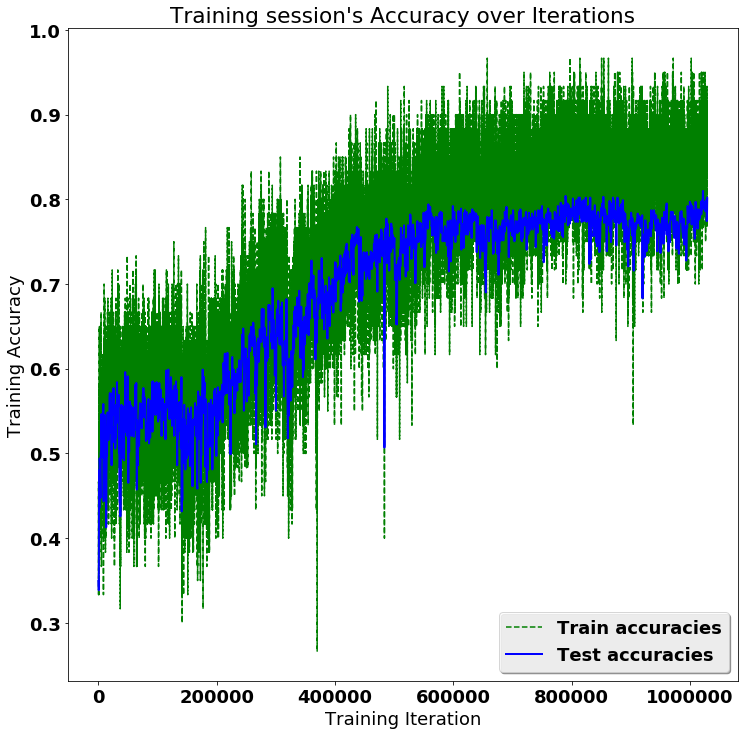

Testing Accuracy: 80.1980197429657%

Precision: 80.19847176241264%
Recall: 80.19801980198021%
f1_score: 80.12773397564436%

Confusion Matrix:
Created using test set of 1010 datapoints, normalised to % of each class in the test dataset


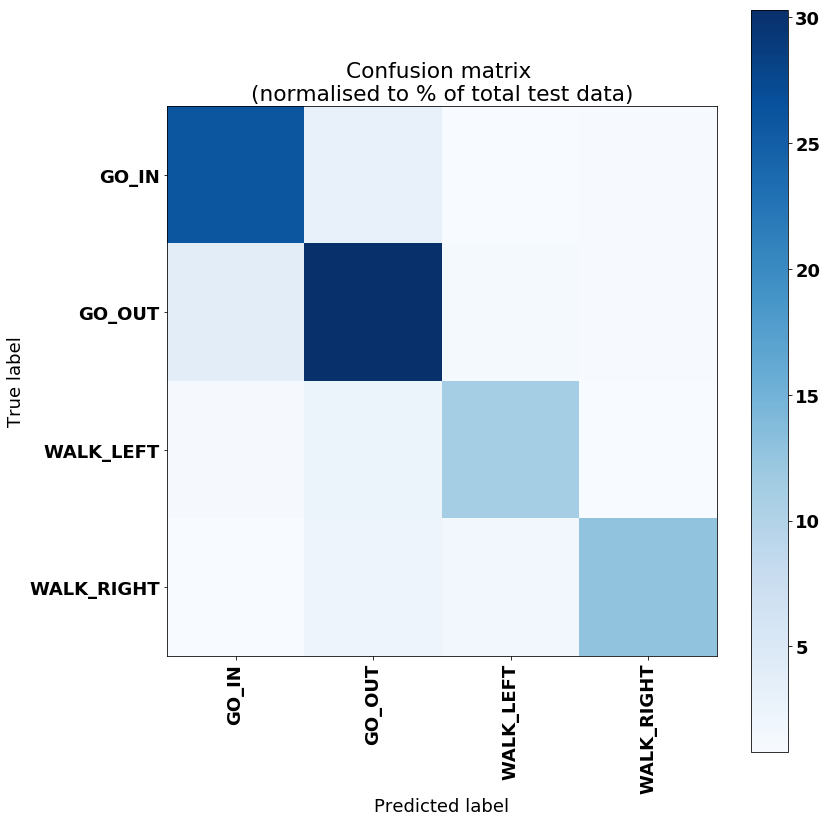

In [15]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy_fin))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [16]:


#
#X_val_path = DATASET_PATH + "X_val.txt"
#X_val = load_X(X_val_path)
#print X_val
#
#preds = sess.run(
#    [pred],
#    feed_dict={
#        x: X_val
#   }
#)
#
#print preds

In [17]:
#sess.close()
print(test_accuracies)

[0.34950495, 0.33861387, 0.48019803, 0.43564355, 0.4940594, 0.48514852, 0.46633664, 0.44752476, 0.5009901, 0.5019802, 0.54653466, 0.5188119, 0.5168317, 0.52079207, 0.54158413, 0.4950495, 0.54752475, 0.55841583, 0.44356436, 0.5049505, 0.5237624, 0.52970296, 0.54554456, 0.52970296, 0.519802, 0.46336633, 0.5049505, 0.4128713, 0.47623762, 0.4980198, 0.4970297, 0.5346535, 0.54851484, 0.52178216, 0.5435644, 0.5158416, 0.5267327, 0.54158413, 0.53267324, 0.56534654, 0.57128716, 0.5247525, 0.5257426, 0.55544555, 0.55346537, 0.5594059, 0.4861386, 0.519802, 0.56336635, 0.57128716, 0.5673267, 0.5752475, 0.5594059, 0.5772277, 0.54554456, 0.54752475, 0.51287127, 0.53168315, 0.5168317, 0.5059406, 0.5118812, 0.55742574, 0.5188119, 0.55544555, 0.5524753, 0.5841584, 0.560396, 0.5366337, 0.56138617, 0.55445546, 0.55643564, 0.5693069, 0.5009901, 0.52178216, 0.46138614, 0.44158417, 0.5168317, 0.42574257, 0.47524753, 0.5277228, 0.5188119, 0.55742574, 0.4940594, 0.54752475, 0.5425743, 0.5267327, 0.5514851, 0

## Conclusion

Final accuracy of >90% is pretty good, considering that training takes about 7 minutes.

Noticeable confusion between activities of Clapping Hands and Boxing, and between Jumping Jacks and Waving Two Hands which is understandable.

In terms of the applicability of this to a wider dataset, I would imagine that it would be able to work for any activities in which the training included a views from all angles to be tested on. It would be interesting to see it's applicability to camera angles in between the 4 used in this dataset, without training on them specifically.

 Overall, this experiment validates the idea that 2D pose can be used for at least human activity recognition, and provides verification to continue onto use of 2D pose for behaviour estimation in both people and animals
 

 ### With regards to Using LSTM-RNNs
 - Batch sampling
     - It is neccessary to ensure you are not just sampling classes one at a time! (ie y_train is ordered by class and batch chosen in order)The use of random sampling of batches without replacement from the training data resolves this.    
 
 - Architecture
     - Testing has been run using a variety of hidden units per LSTM cell, with results showing that testing accuracy achieves a higher score when using a number of hidden cells approximately equal to that of the input, ie 34. The following figure displays the final accuracy achieved on the testing dataset for a variety of hidden units, all using a batch size of 4096 and 300 epochs (a total of 1657 iterations, with testing performed every 8th iteration).
   
 
 

## Future Works

Inclusion of :

 - A pipeline for qualitative results
 - A validation dataset
 - Momentum     
 - Normalise input data (each point with respect to distribution of itself only)
 - Dropout
 - Comparison of effect of changing batch size
 

Further research will be made into the use on more subtle activity classes, such as walking versus running, agitated movement versus calm movement, and perhaps normal versus abnormal behaviour, based on a baseline of normal motion.


## References

The dataset can be found at http://tele-immersion.citris-uc.org/berkeley_mhad released under the BSD-2 license
>Copyright (c) 2013, Regents of the University of California All rights reserved.

The network used in this experiment is based on the following, available under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE). :
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition



In [18]:
# Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown LSTM.ipynb
!mv LSTM.md README.md

[NbConvertApp] Converting notebook LSTM.ipynb to markdown
[NbConvertApp] Writing 389281 bytes to LSTM.md


## 

In [19]:
#### Camera

# import argparse
# import logging
# import time

# import cv2
# import numpy as np

# from tf_pose.estimator import TfPoseEstimator
# from tf_pose.networks import get_graph_path, model_wh

# logger = logging.getLogger('TfPoseEstimator-WebCam')
# logger.setLevel(logging.DEBUG)
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
# ch.setFormatter(formatter)
# logger.addHandler(ch)

# class openpose:
#     def __init__(self, camera=0,resize='0x0',resize_out_ratio=4.0,model='mobilenet_thin',show_process=False):

#         logger.debug('initialization %s : %s' % (model, get_graph_path(model)))
#         w, h = model_wh(resize)
#         if w > 0 and h > 0:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
#         else:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
#         logger.debug('cam read+')
#         cam = cv2.VideoCapture(camera)
#         ret_val, image = cam.read()
#         logger.info('cam image=%dx%d' % (image.shape[1], image.shape[0]))
        
#         fps_time = 0

#         while True:
#             ret_val, image = cam.read()

#             logger.debug('image process+')
#             humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

#             logger.debug('postprocess+')
#             image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

#             logger.debug('show+')
#             cv2.putText(image,
#                         "FPS: %f" % (1.0 / (time.time() - fps_time)),
#                         (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#                         (0, 255, 0), 2)
#             cv2.imshow('tf-pose-estimation result', image)
#             fps_time = time.time()
#             if cv2.waitKey(1) == 27:
#                 break
#             logger.debug('finished+')

#         cv2.destroyAllWindows()

# if __name__ == '__main__':
#     openpose()
